# Library Import and Functions

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Open original reference
original_ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/bernardo/medically_relevant_genes.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

## Import and parse through extended annotations
ref = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

In [8]:
## Fix column names in counts matrix

df = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [9]:
## Calculate total counts and fix gene id
df["total_counts"] = df[df.filter(regex='count').columns].sum(axis=1)

In [10]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()

In [11]:
## Drop ERCCs
df = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [12]:
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [13]:
df = df.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [14]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [15]:
## Drop new mitochondrial transcripts/genes
df_novel_genes = df_novel_genes.loc[df_novel_genes["chr"] != "MT"].copy()
df_novel_transcripts = df_novel_transcripts.loc[df_novel_transcripts["chr"] != "MT"].copy()

In [16]:
## Filter novel genes and transcripts, one only total CPM > 1, other each CPM > 1

df_novel_genes_median = df_novel_genes[df_novel_genes["median_CPM"] > 1].copy()
df_novel_transcripts_median = df_novel_transcripts[df_novel_transcripts["median_CPM"] > 1].copy()

In [17]:
## Get number of transcripts from each filter from each filter

print("Number of transcripts mapping to new gene bodies (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to new gene bodies (median CPM > 1):", df_novel_genes_median.shape[0])

print("\n\nNumber of new transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of new transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to new gene bodies (no filter): 1860
Number of transcripts mapping to new gene bodies (median CPM > 1): 267


Number of new transcripts mapping to annotated genes (no filter): 1534
Number of new transcripts mapping to annotated genes (median CPM > 1): 428


In [18]:
## Get number of genes represented for each filter

print("Number of new genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of new genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())


print("\n\nNumber of represented annotated genes with new transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with new transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of new genes represented (no filter): 1676
Number of new genes represented (median CPM > 1): 245


Number of represented annotated genes with new transcripts (no filter): 1255
Number of represented annotated genes with new transcripts (median CPM > 1): 383


In [19]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_ntng_median = []
list_ntkg_median = []
list_ntkg_median_prot_coding = []
list_ntkg_median_med_relevant = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ntng_median_cpm = df_novel_genes.loc[df_novel_genes["median_CPM"] >= cpm_thresh].copy()
    ntkg_median_cpm = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] >= cpm_thresh].copy()
    
    ntng_median_cpm_num = ntng_median_cpm.shape[0]
    ntkg_median_cpm_num = ntkg_median_cpm.shape[0]
    ntkg_median_cpm_num_prot = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(protein_coding_ref["gene_id"])].shape[0]    
    ntkg_median_cpm_num_med = ntkg_median_cpm.loc[ntkg_median_cpm["gene_id"].isin(disease_relevant_genes_annotated["gene_id"])].shape[0]    
    
    list_cpm_thresh.append(cpm_thresh)
        
    list_ntng_median.append(ntng_median_cpm_num)
    list_ntkg_median.append(ntkg_median_cpm_num)
    list_ntkg_median_prot_coding.append(ntkg_median_cpm_num_prot)
    list_ntkg_median_med_relevant.append(ntkg_median_cpm_num_med)

In [20]:
## Set parameters for figures
from matplotlib import rcParams


# figure size in inches
rcParams['figure.figsize'] = (9, 6)
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

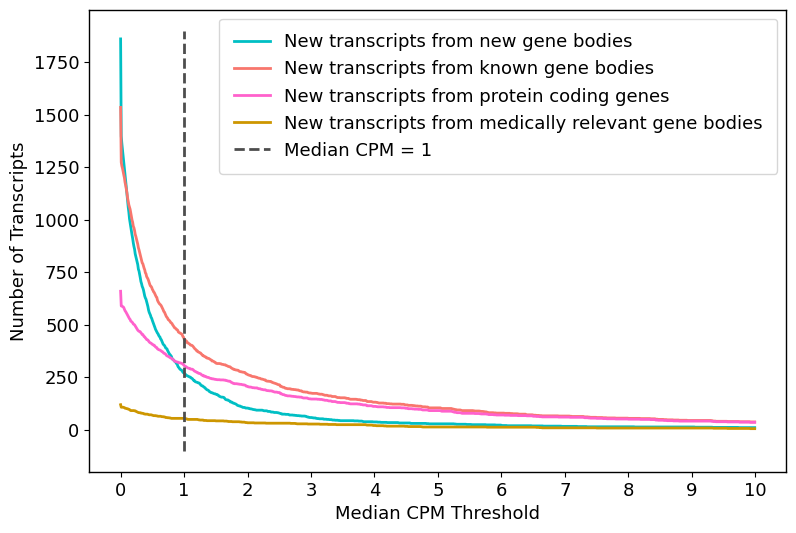

In [21]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_ntng_median, color=ggplot2_colors[4], label="New transcripts from new gene bodies", linewidth=2, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median, color=ggplot2_colors[0], label="New transcripts from known gene bodies", linewidth=2, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_prot_coding, color=ggplot2_colors[7], label="New transcripts from protein coding genes", linewidth=2, alpha=1)
plt.plot(list_cpm_thresh, list_ntkg_median_med_relevant, color=ggplot2_colors[1], label="New transcripts from medically relevant gene bodies", linewidth=2, alpha=1)
plt.plot([1, 1], [-100, 1899], color="#4d4d4d", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", borderpad=0.8)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/number_of_new_transcripts_across_cpm_thresh.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/number_of_new_transcripts_across_cpm_thresh.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# Figures 5 & S1

In [22]:
## Create list o disease relevant novel transcripts for three stringency thresholds
novel_relevant_median = df_novel_transcripts_median.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [23]:
## Drop any duplicates
novel_relevant_median.drop_duplicates(inplace=True)

In [24]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_median_counts = pd.merge(df, novel_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [25]:
## Calculate relative transcript abundance
novel_relevant_median_relative_abundance = relative_transcript_abundance(novel_relevant_median_counts)

In [26]:
## Annotate novel transcripts on relative abundance table
novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_relative_abundance.loc[~novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [27]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_median_words = novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [28]:
## Drop duplicates
novel_relevant_median_words = novel_relevant_median_words.drop_duplicates()

In [29]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_median_words = round(novel_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [30]:
## Create a dataframe to properly store the data
novel_relevant_median_words_df = pd.DataFrame()
novel_relevant_median_words_df['word_count'] = novel_relevant_median_words
novel_relevant_median_words_df["gene_name"] = novel_relevant_median_words.index

In [31]:
## Drop index
novel_relevant_median_words_df.reset_index(inplace=True, drop=True)

In [32]:
novel_relevant_median_words_df.shape[0]

49

In [33]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (median CPM > 1):", novel_relevant_median_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (median CPM > 1): 49


In [34]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 1

word_list_disease_median = ""

for i in range(len(novel_relevant_median_words_df)):
        
    for j in range(int(novel_relevant_median_words_df.iloc[i][0])):
        word_list_disease_median = word_list_disease_median + novel_relevant_median_words_df.iloc[i][1] + " "

In [35]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [36]:
word_cloud_disease_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=2000, height=1000).generate(word_list_disease_median)

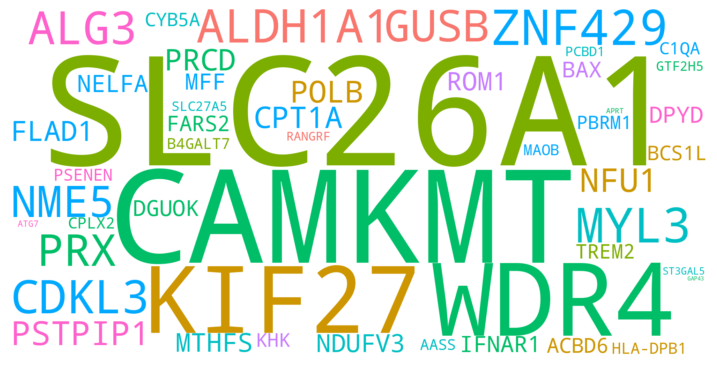

In [37]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/word_cloud_disease_median.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/word_cloud_disease_median.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - Figure 3

In [38]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [39]:
## Make reference only including protein coding transcripts with a defined CDS
orig_ref_cds = original_ref.loc[original_ref["type"]=="CDS"].copy()
orig_ref_cds = parse_df_columns(orig_ref_cds, is_ref=True, is_transcript=True, is_prot=True)

orig_ref_cds = orig_ref_cds.loc[orig_ref_cds["transcript_biotype"] == "protein_coding"].copy()

In [40]:
ref_cds = orig_ref_cds.loc[~orig_ref_cds["ccds_id"].isna()].copy()

ref_cds = ref_cds[["transcript_id", "ccds_id"]].copy().drop_duplicates()

In [41]:
## Create dataframes for AD and med relevant genes, drop Mitochondria
df_med_relevant = df.merge(disease_relevant_genes, on="gene_id", how="inner")
df_med_relevant = df_med_relevant.loc[df_med_relevant["chr"] != "MT"].copy()

df_ad = df.merge(ad_names, on="gene_id", how="inner")
df_ad = df_ad.loc[df_ad["chr"] != "MT"].copy()

In [42]:
## Only keep protein coding transcripts in expression matrix, adding ccds_ids
df_prot_coding_ccds = df.merge(ref_cds[["transcript_id", "ccds_id"]],
                                  how="inner", on="transcript_id").drop_duplicates()

In [43]:
df_prot_coding_ccds.head()

,transcript_id,gene_id,sample_579_PAG75663_CPM,sample_1131_PAM44580_CPM,sample_1218_PAM43779_CPM,sample_1304_PAM44487_CPM,sample_1271_PAM44815_CPM,sample_5356_PAM42933_CPM,sample_1163_PAM44604_CPM,sample_5295_PAG77944_CPM,sample_5292_PAG75292_CPM,sample_1092_PAM41667_CPM,sample_1186_PAM43869_CPM,sample_1291_PAG71816_CPM,total_CPM,median_CPM,chr,ccds_id
0,ENST00000000233,ENSG00000004059,249.28,24.23,213.19,242.91,239.70,228.54,65.03,164.88,217.50,259.25,97.09,181.85,188.55,215.345,7,CCDS34745
1,ENST00000000412,ENSG00000003056,24.20,17.89,17.05,10.76,36.74,28.95,54.90,17.81,30.80,42.20,48.47,39.13,32.21,29.875,12,CCDS8598
2,ENST00000000442,ENSG00000173153,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.000,11,CCDS41667
3,ENST00000001008,ENSG00000004478,157.67,249.18,82.45,217.40,209.63,217.08,205.81,69.55,185.60,204.95,77.89,126.80,157.11,195.275,12,CCDS8512
4,ENST00000001146,ENSG00000003137,3.65,9.15,5.78,6.93,10.65,3.13,0.56,4.64,9.64,20.78,10.77,12.49,8.01,8.040,2,CCDS1919


In [44]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_genes_all_median = []
list_genes_proteins_median = []
list_genes_med_relevant_median = []
list_genes_med_relevant_proteins_median = []
list_genes_ad_median = []
list_genes_ad_proteins_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    df_gene_multiple_all = df.loc[df["median_CPM"] >= cpm_thresh].copy()
    df_gene_mutiple_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] >= cpm_thresh].copy()
    df_gene_mutiple_med = df_med_relevant.loc[df_med_relevant["median_CPM"] >= cpm_thresh].copy()
    df_gene_mutiple_med_prot = df_gene_mutiple_prot.loc[df_gene_mutiple_prot["transcript_id"].isin(df_med_relevant["transcript_id"])].copy()
    df_gene_mutiple_ad = df_ad.loc[df_ad["median_CPM"] > cpm_thresh].copy()
    df_gene_mutiple_ad_prot = df_gene_mutiple_prot.loc[df_gene_mutiple_prot["transcript_id"].isin(df_gene_mutiple_ad["transcript_id"])].copy()

    
    df_gene_mutiple_prot = df_gene_mutiple_prot.loc[~df_gene_mutiple_prot.duplicated(subset=["ccds_id"], keep=False)].copy()
    df_gene_mutiple_prot = df_gene_mutiple_prot.loc[df_gene_mutiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()
    df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[~df_gene_mutiple_med_prot.duplicated(subset=["ccds_id"], keep=False)].copy()
    df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[df_gene_mutiple_med_prot.duplicated(subset=["gene_id"], keep=False)].copy()
    df_gene_mutiple_ad_prot = df_gene_mutiple_ad_prot.loc[~df_gene_mutiple_ad_prot.duplicated(subset=["ccds_id"], keep=False)].copy()
    df_gene_mutiple_ad_prot = df_gene_mutiple_ad_prot.loc[df_gene_mutiple_ad_prot.duplicated(subset=["gene_id"], keep=False)].copy()

    
    num_genes_multiple_isoforms = df_gene_multiple_all.loc[df_gene_multiple_all.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_genes_multiple_prot = df_gene_mutiple_prot["gene_id"].nunique()
    num_genes_multiple_med_relevant = df_gene_mutiple_med.loc[df_gene_mutiple_med.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_med_genes_multiple_prot = df_gene_mutiple_med_prot["gene_id"].nunique()
    num_genes_multiple_ad = df_gene_mutiple_ad.loc[df_gene_mutiple_ad.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_ad_genes_multiple_prot = df_gene_mutiple_ad_prot["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_genes_all_median.append(num_genes_multiple_isoforms)
    list_genes_proteins_median.append(num_genes_multiple_prot)
    list_genes_med_relevant_median.append(num_genes_multiple_med_relevant)
    list_genes_med_relevant_proteins_median.append(num_med_genes_multiple_prot)
    list_genes_ad_median.append(num_genes_multiple_ad)
    list_genes_ad_proteins_median.append(num_ad_genes_multiple_prot)

In [45]:
## Set parameters for figures
from matplotlib import rcParams


# figure size in inches
rcParams['figure.figsize'] = (7, 7)
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

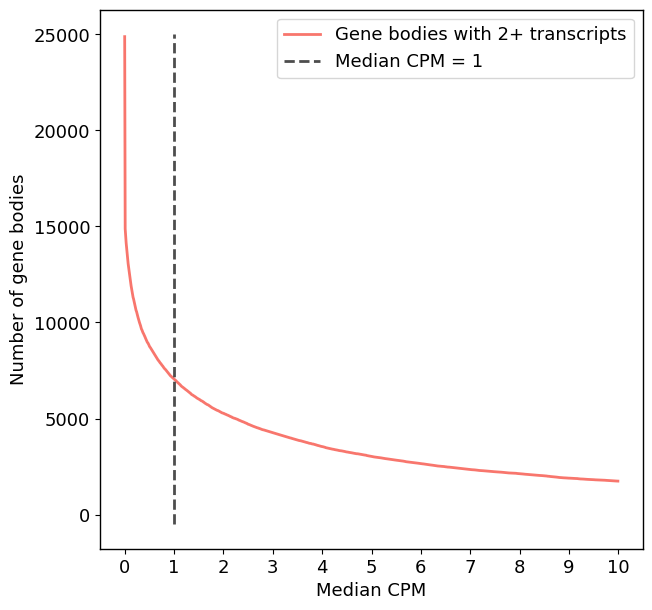

In [46]:
## Make plot showing number of different CDS transcripts from genes expressing 2+ Transcripts with a different CDS

plt.plot(list_cpm_thresh, list_genes_all_median, color=ggplot2_colors[0], label="Gene bodies with 2+ transcripts", linewidth=2, alpha=1)
plt.plot([1, 1], [-500, 25000], color="#4d4d4d", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')



plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM')
plt.ylabel('Number of gene bodies')
plt.legend(loc="upper right")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/genes_with_two_transcripts.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/genes_with_two_transcripts.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [47]:
## Create CPM 1 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()

df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[~df_prot_avg_multiple_iso.duplicated(subset=["ccds_id"], keep=False)].copy()
df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_gene_mutiple_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of Genes"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_avg["Number of Transcripts Encoding Different Proteins"] = df_numbers_prot_multiple_isoforms_median.value_counts().index

In [48]:
## Create CPM 1 Threhold multiple isoform filter

df_gene_mutiple_med = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()
df_gene_mutiple_med = df_gene_mutiple_med.loc[df_gene_mutiple_med.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_median = df_gene_mutiple_med["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters

df_num_isoforms_med_avg = pd.DataFrame()
df_num_isoforms_med_avg["Number of Medically Relevant Genes"] = df_numbers_med_multiple_isoforms_median.value_counts()
df_num_isoforms_med_avg["Number of Transcripts"] = df_numbers_med_multiple_isoforms_median.value_counts().index

In [49]:
## Create CPM 1 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()
df_gene_mutiple_med_prot = df_med_relevant.loc[df_med_relevant["median_CPM"] > 1].copy()


df_gene_mutiple_med_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds['transcript_id'].isin(df_gene_mutiple_med_prot["transcript_id"])].copy()                                                   

df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[~df_gene_mutiple_med_prot.duplicated(subset=["ccds_id"], keep=False)].copy()
df_gene_mutiple_med_prot = df_gene_mutiple_med_prot.loc[df_gene_mutiple_med_prot.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_med_multiple_isoforms_prot_median = df_gene_mutiple_med_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters

df_num_isoforms_med_avg = pd.DataFrame()
df_num_isoforms_med_avg["Number of Medically Relevant Genes Prot"] = df_numbers_med_multiple_isoforms_prot_median.value_counts()
df_num_isoforms_med_avg["Number of Transcripts"] = df_numbers_med_multiple_isoforms_prot_median.value_counts().index

In [50]:
## Set parameters for figures
from matplotlib import rcParams


# figure size in inches
rcParams['figure.figsize'] = (7, 7)
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

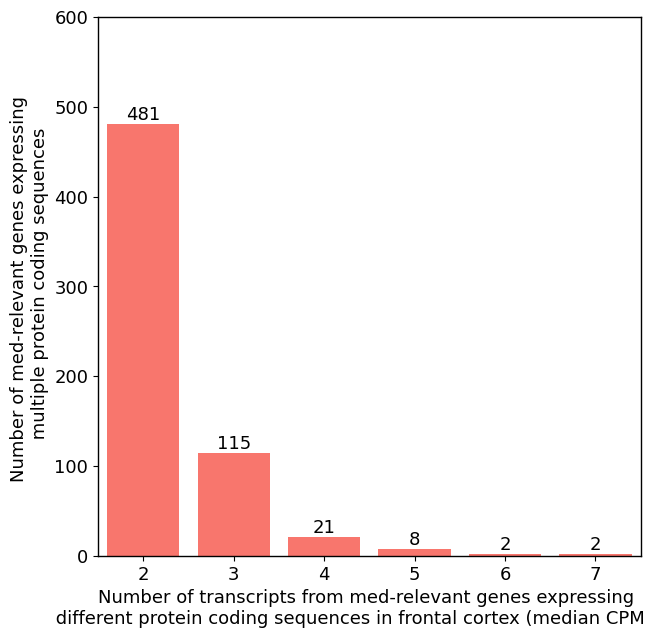

In [51]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_num_isoforms_med_avg, y="Number of Medically Relevant Genes Prot", x="Number of Transcripts",
            color=ggplot2_colors[0], saturation=1)

ax.bar_label(ax.containers[0])
ax.set(ylim=(0, 600))
plt.ylabel("Number of med-relevant genes expressing \n multiple protein coding sequences")
plt.xlabel("Number of transcripts from med-relevant genes expressing \n different protein coding sequences in frontal cortex (median CPM > 1)")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/multiple_prot_seq.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/multiple_prot_seq.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

## - Figure 7

In [52]:
## Get all transcript IDs from ENSEMBL 94 GTF

df_ensembl_94 = ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.94.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

df_ensembl_94 = df_ensembl_94.loc[~df_ensembl_94["chr"].str.startswith("ERCC-")]

df_ensembl_94_transcripts = df_ensembl_94.loc[df_ensembl_94["type"] == "transcript"].copy()

df_ensembl_94_transcripts = parse_df_columns(df_ensembl_94_transcripts, is_ref=True, is_transcript=True)

ensembl_94_transcript_ids = df_ensembl_94_transcripts["transcript_id"].copy()

In [53]:
## Get transcript names from ENSEMBL 107 GTF

ensembl_107_transcripts = original_ref.loc[original_ref["type"] == "transcript"].copy()
ensembl_107_transcripts = parse_df_columns(ensembl_107_transcripts, is_ref=True, is_transcript=True)

In [54]:
## Only keep transcripts that are different between ensembl_94 and ensembl_107

ensembl_107_exclusive_transcripts = ensembl_107_transcripts.loc[~ensembl_107_transcripts["transcript_id"].isin(ensembl_94_transcript_ids)].copy()

In [55]:
## Create list of new CCDS since 2019

## Get all transcript IDs from ENSEMBL 94 GTF
df_ensembl_94_cds = df_ensembl_94.loc[df_ensembl_94["type"] == "CDS"].copy()
df_ensembl_94_cds = parse_df_columns(df_ensembl_94_cds, is_ref=True, is_transcript=True, is_prot=True)
ensembl_94_cds_ccds_ids = df_ensembl_94_cds["ccds_id"].dropna().copy()

## Get transcript names from ENSEMBL 107 GTF
ensembl_107_cds = original_ref.loc[original_ref["type"] == "CDS"].copy()
ensembl_107_cds = parse_df_columns(ensembl_107_cds, is_ref=True, is_transcript=True, is_prot=True)
ensembl_107_cds.dropna(subset="ccds_id")

## Get ensmbl 107 exclusive ccds
ensembl_107_exclusive_ccds = ensembl_107_cds.loc[~ensembl_107_cds["transcript_id"].isin(ensembl_94_transcript_ids)].copy()
ensembl_107_exclusive_ccds = ensembl_107_exclusive_ccds.loc[~ensembl_107_exclusive_ccds["ccds_id"].isin(ensembl_94_cds_ccds_ids)].copy()

In [56]:
## Create counts matrix only including the new transcripts found after ENSEMBL 94

df_exclusive_107_transcripts = df.loc[df["transcript_id"].isin(ensembl_107_exclusive_transcripts["transcript_id"])].copy()
df_exclusive_107_ccds = df.loc[df["transcript_id"].isin(ensembl_107_exclusive_ccds["transcript_id"])].copy()

In [57]:
df_exclusive_107_transcripts.shape

(48155, 17)

In [58]:
df_exclusive_107_ccds.shape

(11901, 17)

In [59]:
## Create lists with numbers of ENSEMBL 107 exclusive transcripts expressed across CPM thresholds

list_cpm_thresh = []

list_ensembl_107_all_transcript_median = []
list_ensembl_107_new_cds_transcript_median = []
list_ensembl_107_med_relevant_transcript_median = []
list_ensembl_107_med_relevant_new_cds_transcript_median = []
list_ensembl_107_ad_relevant_transcript_median = []
list_ensembl_107_ad_relevant_new_cds_transcript_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    ensembl_107_median = df_exclusive_107_transcripts.loc[df_exclusive_107_transcripts["median_CPM"] >= cpm_thresh].copy()
    ensembl_107_new_cds_median = df_exclusive_107_ccds.loc[df_exclusive_107_ccds["median_CPM"] >= cpm_thresh].copy()
    ensembl_107_med_relevant_median = ensembl_107_median.loc[ensembl_107_median["gene_id"].isin(disease_relevant_genes["gene_id"])].copy()
    ensembl_107_med_relevant_new_cds_median = ensembl_107_med_relevant_median.loc[ensembl_107_med_relevant_median["transcript_id"].isin(ensembl_107_new_cds_median["transcript_id"])].copy()
    ensembl_107_ad_relevant_median = ensembl_107_median.loc[ensembl_107_median["gene_id"].isin(ad_names["gene_id"])].copy()
    ensembl_107_ad_relevant_new_cds_median = ensembl_107_ad_relevant_median.loc[ensembl_107_ad_relevant_median["transcript_id"].isin(ensembl_107_new_cds_median["transcript_id"])].copy()
    
    
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_ensembl_107_all_transcript_median.append(ensembl_107_median.shape[0])
    list_ensembl_107_new_cds_transcript_median.append(ensembl_107_new_cds_median.shape[0])
    list_ensembl_107_med_relevant_transcript_median.append(ensembl_107_med_relevant_median.shape[0])
    list_ensembl_107_med_relevant_new_cds_transcript_median.append(ensembl_107_med_relevant_new_cds_median.shape[0])
    list_ensembl_107_ad_relevant_transcript_median.append(ensembl_107_ad_relevant_median.shape[0])
    list_ensembl_107_ad_relevant_new_cds_transcript_median.append(ensembl_107_ad_relevant_new_cds_median.shape[0])

In [60]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10,5
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

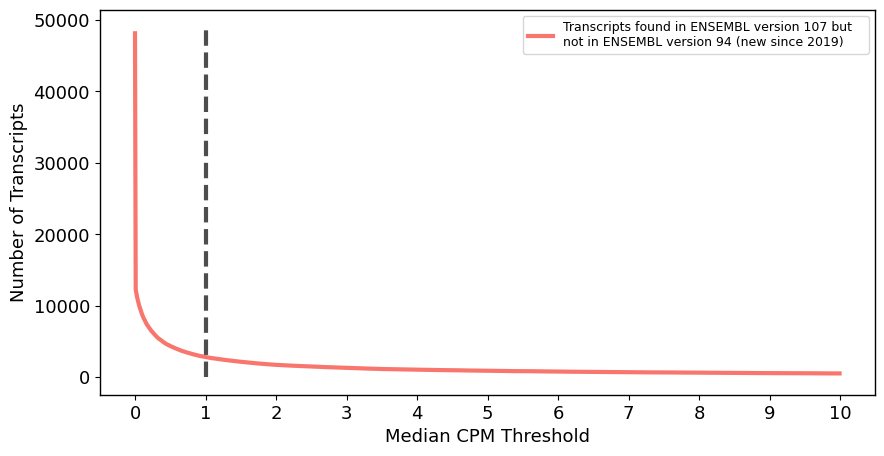

In [61]:
plt.plot(list_cpm_thresh, list_ensembl_107_all_transcript_median, color=ggplot2_colors[0], label="New transcripts since 2019", linewidth=3, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(labels=["Transcripts found in ENSEMBL version 107 but   \nnot in ENSEMBL version 94 (new since 2019)   ", "Median CPM > 1"], loc="upper right", fontsize=9)
plt.plot([1, 1], [-10, 49000], color="#4d4d4d", label="Median CPM = 1", linewidth=3, alpha=1, linestyle='dashed')


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/new_since_2019.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/new_since_2019.svg', dpi=1200, transparent=True, bbox_inches="tight")


In [62]:
df_exclusive_107_transcripts_median = df_exclusive_107_transcripts.loc[df_exclusive_107_transcripts["median_CPM"] > 0].copy()

df_exclusive_107_transcripts_median["Log10 median CPM"] = np.log10(df_exclusive_107_transcripts_median["median_CPM"])

In [63]:
ensembl_107_median_1 = df_exclusive_107_transcripts.loc[df_exclusive_107_transcripts["median_CPM"] > 1].copy()
ensembl_107_new_cds_median_1 = df_exclusive_107_ccds.loc[df_exclusive_107_ccds["median_CPM"] > 1].copy()

ensembl_107_med_relevant_median_1 = ensembl_107_median_1.loc[ensembl_107_median_1["gene_id"].isin(disease_relevant_genes["gene_id"])].copy()
ensembl_107_med_relevant_new_cds_median_1 = ensembl_107_med_relevant_median_1.loc[ensembl_107_med_relevant_median_1["transcript_id"].isin(ensembl_107_new_cds_median_1["transcript_id"])].copy()

ensembl_107_ad_relevant_median_1 = ensembl_107_median_1.loc[ensembl_107_median_1["gene_id"].isin(ad_names["gene_id"])].copy()
ensembl_107_ad_relevant_new_cds_median_1 = ensembl_107_ad_relevant_median_1.loc[ensembl_107_ad_relevant_median_1["transcript_id"].isin(ensembl_107_new_cds_median_1["transcript_id"])].copy()

In [64]:
df_barplot_107 = pd.DataFrame()

df_barplot_107["New Transcript Since 2019 (Median CPM > 1)"] = [ensembl_107_med_relevant_median_1.shape[0], ensembl_107_new_cds_median_1.shape[0],
                                                                ensembl_107_med_relevant_new_cds_median_1.shape[0],
                                               ensembl_107_ad_relevant_median_1.shape[0], ensembl_107_ad_relevant_new_cds_median_1.shape[0]]

df_barplot_107["Description"] = ["Med-relevant", "New protein coding sequence", "Med-relevant new protein coding sequence", 
                                "AD relevant", "AD relevant new protein coding sequence"]

In [65]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 7,7
rcParams.update({'font.size': 11})
rcParams['axes.linewidth'] = 1

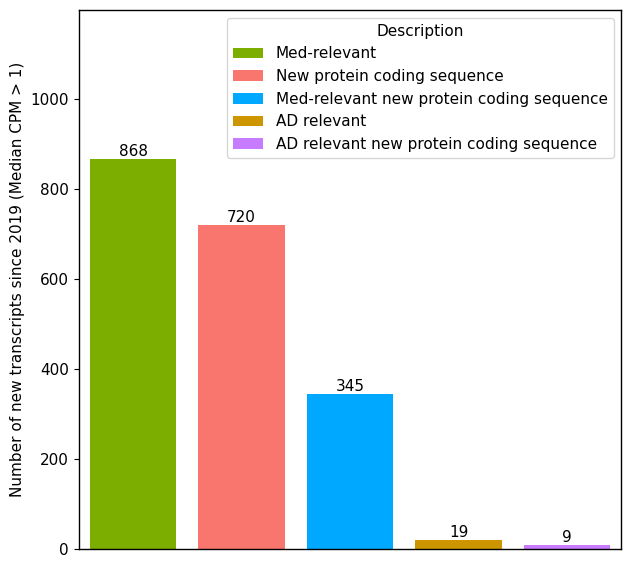

In [66]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_barplot_107, y="New Transcript Since 2019 (Median CPM > 1)", x="Description", hue="Description",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False)

for container in ax.containers:
    ax.bar_label(container)
    
    
ax.set(ylim=(0, 1199))
plt.ylabel('Number of new transcripts since 2019 (Median CPM > 1)')
ax.set(xticklabels=[], xlabel="")
ax.tick_params(bottom=False)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/since_2019_number.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/since_2019_number.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [67]:
## Create dataframe to store percent expression
percent_expression_df = pd.DataFrame()

In [68]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


med_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_med_relevant_median_1["gene_id"])].copy()
med_relevant_relative_abundance = relative_transcript_abundance(med_percent_expression)

med_final_percent_expression = med_relevant_relative_abundance.loc[med_relevant_relative_abundance["transcript_id"].isin(ensembl_107_med_relevant_median_1["transcript_id"])]
med_final_percent_expression = med_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
med_final_percent_expression = med_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = med_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = med_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = med_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Med-relevant"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [69]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()

cds_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_new_cds_median_1["gene_id"])].copy()
cds_relevant_relative_abundance = relative_transcript_abundance(cds_percent_expression)

cds_final_percent_expression = cds_relevant_relative_abundance.loc[cds_relevant_relative_abundance["transcript_id"].isin(ensembl_107_new_cds_median_1["transcript_id"])]
cds_final_percent_expression = cds_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
cds_final_percent_expression = cds_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = cds_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = cds_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = cds_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "New protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [70]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


med_cds_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_med_relevant_new_cds_median_1["gene_id"])].copy()
med_cds_relevant_relative_abundance = relative_transcript_abundance(med_cds_percent_expression)

med_cds_final_percent_expression = med_cds_relevant_relative_abundance.loc[med_cds_relevant_relative_abundance["transcript_id"].isin(ensembl_107_med_relevant_new_cds_median_1["transcript_id"])]
med_cds_final_percent_expression = med_cds_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
med_cds_final_percent_expression = med_cds_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = med_cds_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = med_cds_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = med_cds_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "Med-relevant new protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [71]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


ad_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_ad_relevant_median_1["gene_id"])].copy()
ad_relevant_relative_abundance = relative_transcript_abundance(ad_percent_expression)

ad_final_percent_expression = ad_relevant_relative_abundance.loc[ad_relevant_relative_abundance["transcript_id"].isin(ensembl_107_ad_relevant_median_1["transcript_id"])]
ad_final_percent_expression = ad_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
ad_final_percent_expression = ad_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = ad_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = ad_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = ad_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "AD relevant"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

In [72]:
## Get percent expression from transcripts since 2019 for each subcategory
df_tmp = pd.DataFrame()


ad_new_prot_percent_expression = df.loc[df["gene_id"].isin(ensembl_107_ad_relevant_new_cds_median_1["gene_id"])].copy()
ad_new_prot_relevant_relative_abundance = relative_transcript_abundance(ad_new_prot_percent_expression)

ad_new_prot_final_percent_expression = ad_new_prot_relevant_relative_abundance.loc[ad_new_prot_relevant_relative_abundance["transcript_id"].isin(ensembl_107_ad_relevant_new_cds_median_1["transcript_id"])]
ad_new_prot_final_percent_expression = ad_new_prot_final_percent_expression.groupby('gene_id')['relative_abundance_percent'].sum().reset_index()
ad_new_prot_final_percent_expression = ad_new_prot_final_percent_expression.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

df_tmp['Gene ID'] = ad_new_prot_final_percent_expression["gene_id"].copy()
df_tmp['Gene Name'] = ad_new_prot_final_percent_expression["gene_name"].copy()
df_tmp['Relative Abundance of New Transcripts Since 2019 (%)'] = ad_new_prot_final_percent_expression["relative_abundance_percent"].copy()
df_tmp["Category"] = "AD relevant new protein coding sequence"

percent_expression_df = pd.concat([percent_expression_df, df_tmp])

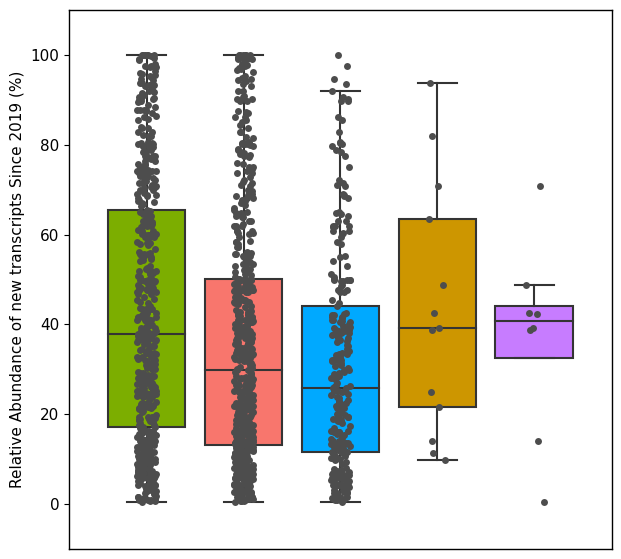

In [73]:
ax = sns.boxplot(data=percent_expression_df, y="Relative Abundance of New Transcripts Since 2019 (%)", x="Category", 
                 hue="Category",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1, dodge=False, showfliers=False)

sns.stripplot(data=percent_expression_df, y="Relative Abundance of New Transcripts Since 2019 (%)", x="Category",
             color="#4d4d4d")


ax.set(ylim=(-10, 110))
ax.set(xlim=(-0.8, 4.8))
ax.set(xticklabels=[], ylabel="Relative Abundance of new transcripts Since 2019 (%)", xlabel="")
ax.tick_params(bottom=False)


plt.legend([],[], frameon=False)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/since_2019_percent.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/since_2019_percent.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - Memes for figures

In [74]:
### 3 PRIME NFN ###

nfn_3_prime_in = open("../../../data/maddy/MEME/three_prime_splice_sites_nfn_12s.fa", 'r')
Lines_in = nfn_3_prime_in.readlines()


nfn_3_prime_out = open("../../../data/maddy/MEME/three_prime_splice_sites_nfn_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][10:12] == "AG"):
        print(Lines_in[i])
        print(Lines_in[i][10:12])
        nfn_3_prime_out.write(Lines_in[i-1])
        nfn_3_prime_out.write(Lines_in[i])
        
nfn_3_prime_out.close()

nfn_3_prime_out = open("../../../data/maddy/MEME/three_prime_splice_sites_nfn_12s_VALIDATED.fa", 'r')
Lines_out = nfn_3_prime_out.readlines()

percent_3_nfn = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfn_3_prime_out.close()

TCCTGACCTCAGG

AG
GATGTTACCGAGG

AG
TTTACAAAGTAGT

AG
TATTTGACAAAGT

AG
AAAGCTTTTTAGT

AG
CTTGTTTTGCAGG

AG
GGGGAGAAACAGT

AG
GGCCTCCCAAAGG

AG
ACTGCACTCCAGC

AG
CTCCCAAAGAAGA

AG
AAAGTACTGGAGT

AG
AGGGAGGTGGAGG

AG
CTGTAGTCCCAGC

AG
CTTTCCCTACAGA

AG
ACATACATTCAGG

AG
AAAAAAGCCAAGT

AG
GCGCCCGGCCAGG

AG
TTTCACCTATAGT

AG
CAGAGCTTGCAGT

AG
TGCAGTCAGCAGA

AG
GATGTGCATCAGT

AG
AAAGAAATGCAGT

AG
GGTCCCTTTCAGA

AG
ACTGTGGGCCAGG

AG
TCTCCCCAACAGG

AG
TGGTCTTCTCAGC

AG
AAAAAAAAAAAGA

AG
TGGGAGGCTGAGG

AG
ATCACACTCAAGA

AG
AGCTGCACACAGG

AG
AGGCCTCCGGAGT

AG
ACTCTTGTTCAGG

AG
AAAAGAAGGGAGT

AG
CTGTATTCCCAGC

AG
ACTGTTCTCCAGC

AG
GGGTGCTATTAGT

AG
AATGGGGTAAAGT

AG
ACAAGACTACAGT

AG
TCGAGGCTGCAGT

AG
TCCTGAATGTAGT

AG
GCCCCTAAACAGG

AG
CTTCCCCGGCAGT

AG
ATCTATATATAGA

AG
ACCTGAGGTCAGG

AG
ACCCCATCTTAGG

AG
TTCCAATAACAGG

AG
TTCAACTTCTAGA

AG
AATTCAGGCCAGC

AG
TGTCCTTTTCAGG

AG
AGCAACACAAAGT

AG
GAGGTGCTTAAGT

AG
CCCTGTGGACAGG

AG
TCCACATTTCAGA

AG
CTCCTGCCTCAGC

AG
CCTGGACGACAGA

AG
CACTGAAAGT

In [75]:
### 5 PRIME NFN ###

nfn_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_nfn_12s.fa", 'r')
Lines_in = nfn_5_prime_in.readlines()

nfn_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfn_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to filesf
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        print(Lines_in[i])
        nfn_5_prime_out.write(Lines_in[i-1])
        nfn_5_prime_out.write(Lines_in[i])
        
nfn_5_prime_out.close()

nfn_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfn_12s_VALIDATED.fa", 'r')
Lines_out = nfn_5_prime_out.readlines()

percent_5_nfn = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfn_5_prime_out.close()

CTCGTGATC

GCAGTGGAG

TCCGTCTAC

GGAGTCCTA

TTAGTAAAC

GAGGTGGGG

ACAGTGGCG

AGAGTTCCT

TTAGTCAGG

CGGGTAGTG

GGAGTACAG

CAGGTAGCT

TGGGTGAGT

CAAGTATGT

CAAGTCGGC

GCTGTTTTT

AAGGTAAGA

GCAGTGGCG

GAAGTAGTT

TCAGTGACT

GCAGTCGGC

GTTGTTAAT

CAGGTGATC

GGGGTATGT

GAGGTGGGA

AGAGTAAGC

ACAGTGCAG

CGAGTCTCC

GAGGTAGGA

GGAGTGAAA

AAGGTGGGT

TTAGTCCCC

AAAGTGAGG

ACAGTAACC

CCTGTGGTC

GTTGTGTGG

CAGGTTTTT

TCTGTATAT

GGAGTTCGA

ACGGTAAGA

CCAGTAACA

GAGGTAAAG

GCTGTGGGC

TTGGTGAGT

TTTGTGTTG

TCTGTGCCT

ACAGTAAGT

GAGGTGACA

TCGGTAGGC

GCAGTGGCA

CATGTACAT

GAGGTTCGC

TAGGTTTTC

TGGGTACTC

TCTGTGTCT

TTTGTGGCC

CCTGTGATA

GAAGTATGA

GTGGTGAGC

GGGGTGAGG

ACAGTGGGG

TTAGTGGGA

TCCGTCAGG

CAGGTGCGA

GAAGTGGCT

TTAGTAGAG

AGTGTGTGT

GGCGTGAGC

GCAGTGGGA

CCAGTGATT

AGGGTGAGT

CAGGTGCGT

AGGGTGAGT

CAGGTGCGT

GGAGTGCAG

GGGGTGAGT

AAGGTGGGC

TGGGTGCAG

CAGGTACAG

TCAGTCTCC

CGAGTGCCA

ACAGTGCTA

AGGGTGGGG

TAGGTGCTG

CAGGTACTC

CAGGTAGCA

CCGGTGAGG

GAGGTCAGA

CAAGTGAGT

GGGGTGAGG

AAGGTAACA


In [76]:
### 5 PRIME NFK ### - GOOD!

nfk_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_nfki_12s.fa", 'r')
Lines_in = nfk_5_prime_in.readlines()

nfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        nfk_5_prime_out.write(Lines_in[i-1])
        nfk_5_prime_out.write(Lines_in[i])
        
nfk_5_prime_out.close()

nfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_nfk_12s_VALIDATED.fa", 'r')
Lines_out = nfk_5_prime_out.readlines()

percent_5_nfk = round((len(Lines_out)/len(Lines_in)) * 100, 4)

nfk_5_prime_out.close()

In [77]:
### 5 PRIME KFK ### - GOOD!

kfk_5_prime_in = open("../../../data/maddy/MEME/five_prime_splice_sites_kfk_12s.fa", 'r')
Lines_in = kfk_5_prime_in.readlines()

kfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_kfk_12s_VALIDATED.fa", 'w')

## Create lists with read ids for split files and write lines to files
for i in range(1, len(Lines_in), 2):

    if (Lines_in[i][3:5] == "GT"):
        kfk_5_prime_out.write(Lines_in[i-1])
        kfk_5_prime_out.write(Lines_in[i])
        
kfk_5_prime_out.close()

kfk_5_prime_out = open("../../../data/maddy/MEME/five_prime_splice_sites_kfk_12s_VALIDATED.fa", 'r')
Lines_out = kfk_5_prime_out.readlines()

percent_5_kfk = round((len(Lines_out)/len(Lines_in)) * 100, 4)

kfk_5_prime_out.close()

In [78]:
five_prime_kfk = percent_5_kfk
three_prime_kfk = round((160025/160416) * 100, 4)

five_prime_nfk = percent_5_nfk
three_prime_nfk = round((479/479) * 100, 4)

five_prime_nfn = percent_5_nfn
three_prime_nfn = percent_3_nfn

five_prime_nfm = round((16/33) * 100, 4)
three_prime_nfm = round((32/32) * 100, 4)

In [79]:
dict_meme = {"Percent exons containing motiff": [five_prime_nfn, five_prime_nfk, five_prime_kfk, three_prime_nfn, three_prime_nfk, three_prime_kfk], 
            "Splice site motiff": ["Five prime splice site motiff", "Five prime splice site motiff", "Five prime splice site motiff",
                                   "Three prime splice site motiff", "Three prime splice site motiff", "Three prime splice site motiff"],
           "Category": ["New transcripts for new gene body", "New transcripts for known gene body", "Annotated transcripts",
                        "New transcripts for new gene body", "New transcripts for known gene body", "Annotated transcripts"]}

df_meme = pd.DataFrame(dict_meme)

In [80]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 7,7
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

/tmp/ipykernel_488948/63306510.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")


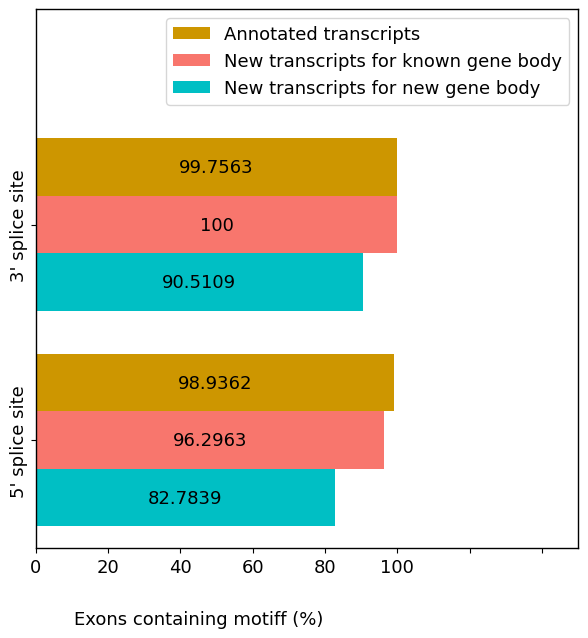

In [81]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=df_meme, x="Percent exons containing motiff", y="Splice site motiff", hue="Category",
                 palette=[ggplot2_colors[4], ggplot2_colors[0], ggplot2_colors[1]], errorbar=None, saturation=1,
                hue_order=df_meme["Category"].unique())

for container in ax.containers:
    ax.bar_label(container, label_type="center")
    
    
ax.set(xlim=(0, 150), ylim=(-0.5, 2))
plt.legend(loc='upper right', borderpad=0.8, fontsize=13)
plt.xlabel('Exons containing motiff (%)')
ax.xaxis.set_label_coords(0.30, -0.115)

ax.set(xticklabels=[0, 20, 40, 60, 80, 100], ylabel="")
ax.set_yticklabels(labels=["5' splice site\n", "3' splice site\n"], rotation=90, ha="center", rotation_mode="anchor")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[i] for i in [2, 1, 0]], [labels[i] for i in [2,1,0]])

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/MEME.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/MEME.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# QC Figures

In [82]:
## QC Figures 

sample_names = ['sample_579_PAG75663', 'sample_1131_PAM44580','sample_1218_PAM43779', 'sample_1304_PAM44487',
 'sample_1271_PAM44815', 'sample_5356_PAM42933', 'sample_1163_PAM44604', 'sample_5295_PAG77944',
 'sample_5292_PAG75292', 'sample_1092_PAM41667', 'sample_1186_PAM43869', 'sample_1291_PAG71816']


percent_mito = [13, 7, 23, 6, 9, 9, 8, 23, 13, 10, 8, 18]

total_reads = [156.3, 166.6, 196.7, 119.4, 108.4, 158.9, 104.1, 163.9, 129.7, 163.5, 183.0, 121.2]

pass_reads = [116.6, 120.1, 153.6, 85.9, 86.8, 119.2, 84.8, 122.7, 98.3, 121.2, 129.7, 91.8]

percent_both_primers = [0.817, 0.862, 0.873, 0.813, 0.773, 0.806, 0.746, 0.765, 0.801, 0.826, 0.871, 0.768]

mapped_reads = [51.8, 22.5, 46.7, 22.6, 44.6, 28.0, 49.1, 40.4, 45.0, 36.1, 34.2, 40.1]

n50_mapped = [831, 1120, 699, 1510, 1370, 1560, 1090, 815, 1040, 1010, 802, 954]

median_read_length_mapped = [336, 245, 286, 422, 458, 327, 500, 354, 393, 259, 328, 416]



dictionary_qc = {'sample_name': sample_names, 'Mapped pass N50': n50_mapped,
                "Median read length mapped": median_read_length_mapped, "All reads": total_reads, 
                "Pass reads": pass_reads, "Mapped pass reads with both primers": mapped_reads, "Percent both primers": percent_both_primers,
                 "percent mito": percent_mito}

df_qc_stats = pd.DataFrame(data=dictionary_qc)

df_qc_stats["Pass reads with both primers"] = df_qc_stats["Pass reads"].copy() * df_qc_stats["Percent both primers"].copy()

In [83]:
df_read_numbers = df_qc_stats[["sample_name", "All reads", "Pass reads"]].copy()

df_read_numbers_melt = pd.melt(df_read_numbers, id_vars=['sample_name'], value_vars=["All reads", "Pass reads"],
                               value_name="Million reads")


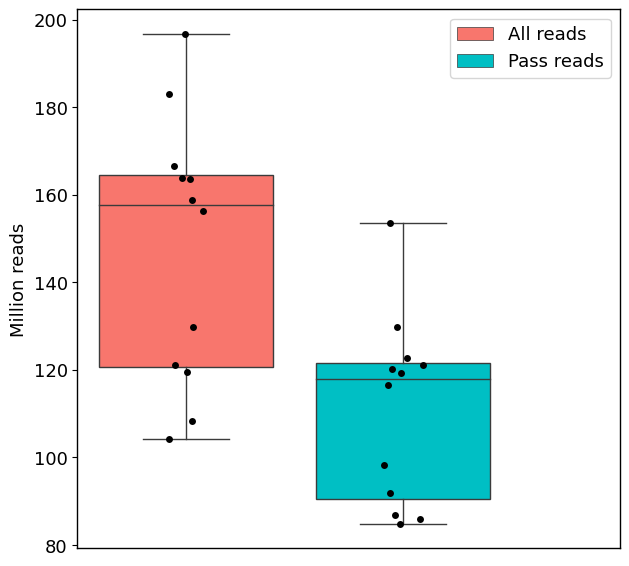

In [84]:
sns.boxplot(data=df_read_numbers_melt, y="Million reads", x="variable",
           saturation=1, palette=[ggplot2_colors[0], ggplot2_colors[4]],
           showfliers=False, hue="variable", dodge=False, linewidth=1)


sns.stripplot(data=df_read_numbers_melt,  y="Million reads", x="variable",
             color="black")


plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)
plt.legend(loc="upper right")


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/number_of_reads.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/number_of_reads.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# Mass Spec 

In [85]:
## Load protein data

df_mass_spec_validation = pd.read_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/unique_pep_hits_new_transcripts.tsv", 
                                     sep="\t")

In [86]:
df_mass_spec_validation.head()

,PSM_ID,accession,sequence,opt_global_q-value,opt_global_feature_id,opt_global_cv_MS:1000889_peptidoform_sequence,spectra_ref
0,4717,var_BambuTx1529_3,RPPEDCTPGPHLSCPSLLSPGGGR,0.001415,429603235518218219,RPPEDC(Carbamidomethyl)TPGPHLSC(Carbamidomethyl)PSLLSPGGGR,ms_run[48]:controllerType=0 controllerNumber=1 scan=1183
1,5110,var_BambuTx1648_3,TDSSPEPLPAGAWPYR,0.000243,769151059970649990,TDSSPEPLPAGAWPYR,ms_run[57]:controllerType=0 controllerNumber=1 scan=1334
2,5111,var_BambuTx1648_3,TDSSPEPLPAGAWPYR,0.002184,6436425096483275553,TDSSPEPLPAGAWPYR,ms_run[67]:controllerType=0 controllerNumber=1 scan=1314
3,11468,var_BambuTx1755_2,GASSNTFR,0.099482,7764014310540513083,GASSNTFR,ms_run[4]:controllerType=0 controllerNumber=1 scan=2411
4,12543,var_BambuTx2900_3,GVQGVGNGEGFEEGIGM,0.059140,15330314474997961006,GVQGVGNGEGFEEGIGM(Oxidation),ms_run[43]:controllerType=0 controllerNumber=1 scan=2259


In [87]:
df_mass_spec_validation = df_mass_spec_validation.loc[df_mass_spec_validation["opt_global_q-value"] <= 0.05].copy()

In [89]:
df_mass_spec_validation["transcript_id"] = df_mass_spec_validation["accession"].str.split("_", expand=True)[1].copy()

In [90]:
df_mass_spec_novel_genes = df_mass_spec_validation.merge(df_novel_genes_median[["transcript_id", "gene_id"]], on="transcript_id",
                                                        how="inner")

In [91]:
df_mass_spec_novel_transcripts = df_mass_spec_validation.merge(df_novel_transcripts_median[["transcript_id", "gene_id"]], on="transcript_id",
                                                        how="inner")

In [92]:
df_mass_spec_novel_transcripts = df_mass_spec_novel_transcripts.merge(orig_ref[["gene_id", "gene_name"]], how="inner", on="gene_id")

In [93]:
df_mass_spec_novel_transcripts['transcript_id'].nunique()

30

In [94]:
df_mass_spec_novel_genes["transcript_id"].nunique()

7

In [97]:
df_mass_spec_novel_genes.head(10)

,PSM_ID,accession,sequence,opt_global_q-value,opt_global_feature_id,opt_global_cv_MS:1000889_peptidoform_sequence,spectra_ref,transcript_id,gene_id
0,27506,var_BambuTx2703_1,GNHRTTSGFSVFQCIQF,0.034620,3484447963731939211,GNHRTTSGFSVFQC(Carbamidomethyl)IQF,ms_run[21]:controllerType=0 controllerNumber=1 scan=4156,BambuTx2703,BambuGene290099
1,602188,var_BambuTx2703_1,PSPDSSIFMPASPSFSLSPPR,0.026540,12502571596657795181,PSPDSSIFM(Oxidation)PASPSFSLSPPR,ms_run[1]:controllerType=0 controllerNumber=1 scan=56031,BambuTx2703,BambuGene290099
2,987279,var_BambuTx2703_1,SPSPDSSIFMPASPSFSLSPPR,0.001762,11072293592973490764,SPSPDSSIFM(Oxidation)PASPSFSLSPPR,ms_run[29]:controllerType=0 controllerNumber=1 scan=72191,BambuTx2703,BambuGene290099
3,134659,var_BambuTx1025_2,LACRPAMTEQLR,0.000277,16467764547025353213,LAC(Carbamidomethyl)RPAM(Oxidation)TEQLR,ms_run[58]:controllerType=0 controllerNumber=1 scan=12261,BambuTx1025,BambuGene144943
4,385534,var_BambuTx1025_2,MVVVVVMMVMVVIVMMMVAMVVIVVMMCDADDDNGR,0.023899,8975584755117588398,MVVVVVM(Oxidation)M(Oxidation)VMVVIVMMMVAM(Oxidation)VVIVVMMC(Carbamidomethyl)DADDDNGR,ms_run[15]:controllerType=0 controllerNumber=1 scan=28806,BambuTx1025,BambuGene144943
5,500215,var_BambuTx1025_2,VAMVVIVVMMCDADDDNGR,0.018162,7117886939087615686,VAM(Oxidation)VVIVVM(Oxidation)M(Oxidation)C(Carbamidomethyl)DADDDNGR,ms_run[19]:controllerType=0 controllerNumber=1 scan=35985,BambuTx1025,BambuGene144943
6,293279,var_BambuTx2710_1,VVGRETGGGGGKVAGRGGGGVR,0.041488,8534963670372775933,VVGRETGGGGGKVAGRGGGGVR,ms_run[49]:controllerType=0 controllerNumber=1 scan=21408,BambuTx2710,BambuGene17443
7,358021,var_BambuTx2710_1,VAGRGTGGGGGRVVGR,0.013887,3208710839028420813,VAGRGTGGGGGRVVGR,ms_run[31]:controllerType=0 controllerNumber=1 scan=24474,BambuTx2710,BambuGene17443
8,467623,var_BambuTx2710_1,GAGGGGGKVAGRGAGGGGGGR,0.031859,11903140802859282749,GAGGGGGKVAGRGAGGGGGGR,ms_run[1]:controllerType=0 controllerNumber=1 scan=45867,BambuTx2710,BambuGene17443
9,566393,var_BambuTx2710_1,GTEGGGGRVAGRGAG,0.042212,9368581377543956622,GTEGGGGRVAGRGAG,ms_run[29]:controllerType=0 controllerNumber=1 scan=35532,BambuTx2710,BambuGene17443


In [89]:
df_mass_spec_novel_transcripts_med_relevant = df_mass_spec_novel_transcripts.merge(disease_relevant_genes_annotated["gene_id"], on="gene_id")

In [90]:
number_of_transcripts = [df_novel_transcripts_median["transcript_id"].nunique(), 
                         df_mass_spec_novel_transcripts['transcript_id'].nunique(),
                         df_novel_genes_median["transcript_id"].nunique(),
                         df_mass_spec_novel_genes["transcript_id"].nunique()]

dict_mass_spec_graph = {"Number of transcripts": number_of_transcripts,
                       "Level": ["RNAseq discovery", "Mass-spec validated", "RNAseq discovery", "Mass-spec validated"],
                       "Description": ["New transcript for known gene body", "New transcript for known gene body", 
                                      "New transcript for new gene body", "New transcript for new gene body"]}


mass_spec_graph = pd.DataFrame(data=dict_mass_spec_graph)

In [91]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10,5
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

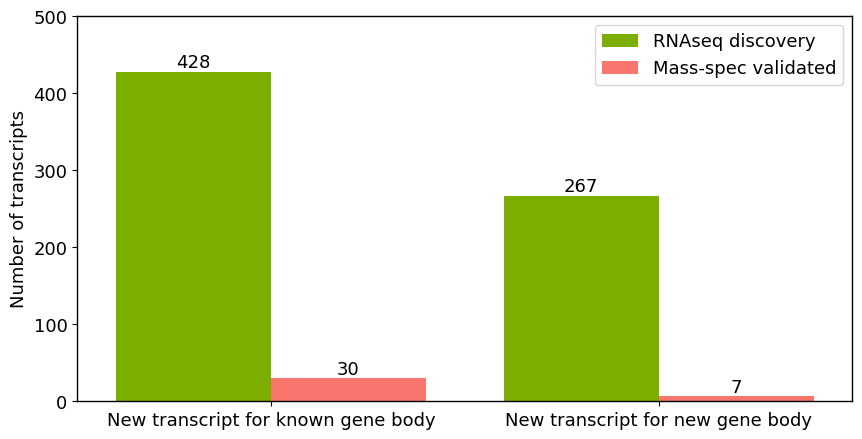

In [92]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.barplot(data=mass_spec_graph,  x="Description", y="Number of transcripts", hue="Level",
            palette=[ggplot2_colors[2], ggplot2_colors[0], ggplot2_colors[5], ggplot2_colors[1], ggplot2_colors[6]], 
                 saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
    
ax.set(ylim=(0, 500))
#plt.ylabel('Number of new transcripts since 2019 (Median CPM > 1)')
ax.set(xlabel="")
plt.legend(loc="upper right")
#ax.tick_params(bottom=False)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/mass_spec_val.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/mass_spec_val.svg', dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [93]:
mass_spec_words = df_mass_spec_novel_transcripts_med_relevant["gene_name"].tolist()

In [94]:
mass_spec_words_string = ""

for word in mass_spec_words:
    
    mass_spec_words_string = mass_spec_words_string + word
    mass_spec_words_string = mass_spec_words_string + " " 

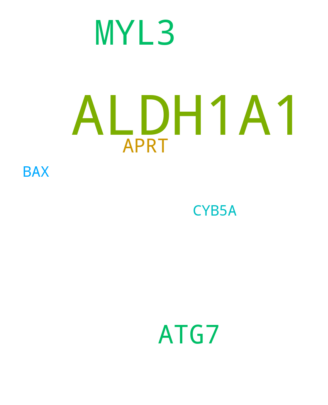

In [95]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

word_cloud_mass_spec = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=800, height=1000).generate(mass_spec_words_string)

## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_mass_spec, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/mass_spec_val_disease_relevant.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/nature_biotech_pitch/mass_spec_val_disease_relevant.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()